In [1]:
%matplotlib inline


ASR example
===========

Denoise data using Artifact Subspace Reconstruction.

Uses meegkit.ASR().


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from meegkit.asr import ASR
from meegkit.utils.asr import yulewalk_filter
from meegkit.utils.matrix import sliding_window

# THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
raw = np.load(os.path.join('..', 'tests', 'data', 'eeg_raw.npy'))
sfreq = 250

Calibration and processing
-----------------------------------------------------------------------------



In [3]:
# Train on a clean portion of data
asr = ASR(method='euclid')
train_idx = np.arange(0 * sfreq, 30 * sfreq, dtype=int)
_, sample_mask = asr.fit(raw[:, train_idx])

# Apply filter using sliding (non-overlapping) windows
X = sliding_window(raw, window=int(sfreq), step=int(sfreq))
Y = np.zeros_like(X)
for i in range(X.shape[1]):
    Y[:, i, :] = asr.transform(X[:, i, :])

raw = X.reshape(8, -1)  # reshape to (n_chans, n_times)
clean = Y.reshape(8, -1)

Plot the results
-----------------------------------------------------------------------------

Data was trained on a 40s window from 5s to 45s onwards (gray filled area).
The algorithm then removes portions of this data with high amplitude
artifacts before running the calibration (hatched area = good).



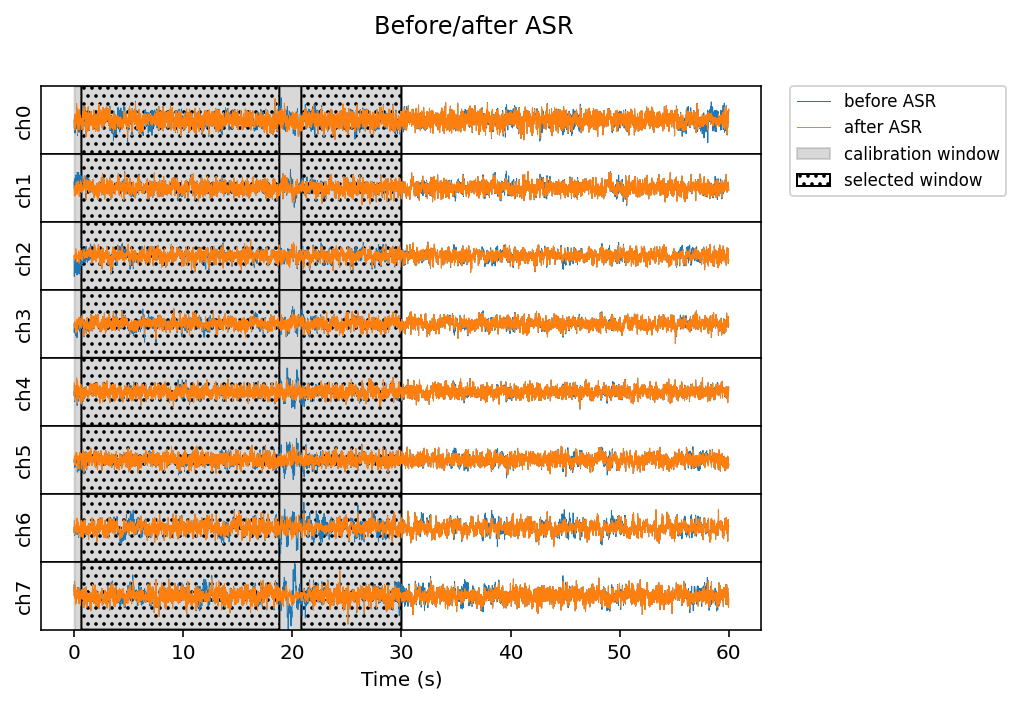

In [4]:
times = np.arange(raw.shape[-1]) / sfreq
f, ax = plt.subplots(8, sharex=True, figsize=(8, 5))
for i in range(8):
    ax[i].fill_between(train_idx / sfreq, 0, 1, color='grey', alpha=.3,
                       transform=ax[i].get_xaxis_transform(),
                       label='calibration window')
    ax[i].fill_between(train_idx / sfreq, 0, 1, where=sample_mask.flat,
                       transform=ax[i].get_xaxis_transform(),
                       facecolor='none', hatch='...', edgecolor='k',
                       label='selected window')
    ax[i].plot(times, raw[i], lw=.5, label='before ASR')
    ax[i].plot(times, clean[i], label='after ASR', lw=.5)
    ax[i].set_ylim([-50, 50])
    ax[i].set_ylabel(f'ch{i}')
    ax[i].set_yticks([])
ax[i].set_xlabel('Time (s)')
ax[0].legend(fontsize='small', bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.subplots_adjust(hspace=0, right=0.75)
plt.suptitle('Before/after ASR')
plt.show()